First five rows of the dataset:
         Soilcolor    Ph        K       P     N        Zn       S    QV2M-W  \
0  Yellowish brown  5.81  738.231   5.401  0.23  2.976000  13.816  7.993333   
1  Yellowish brown  5.43  606.382  10.478  0.23  3.077000  16.421  7.993333   
2            brown  5.41  386.580   6.847  0.23  6.611000  16.557  7.993333   
3              red  5.65  207.086   3.418  0.23  0.460181  16.075  7.993333   
4              red  5.27  317.357  39.282  0.23  2.743000  12.558  7.993333   

     QV2M-Sp    QV2M-Su  ...  PRECTOTCORR-W  PRECTOTCORR-Sp  PRECTOTCORR-Su  \
0  10.456667  11.963333  ...       2.073333            5.27       12.303333   
1  10.456667  11.963333  ...       2.073333            5.27       12.303333   
2  10.456667  11.963333  ...       2.073333            5.27       12.303333   
3  10.456667  11.963333  ...       2.073333            5.27       12.303333   
4  10.456667  11.963333  ...       2.073333            5.27       12.303333   

   PRECTOTCORR-Au 

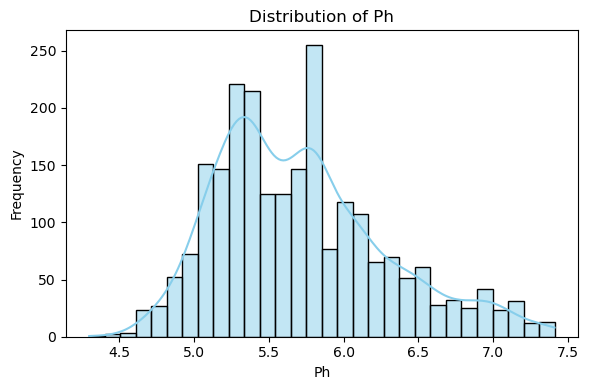

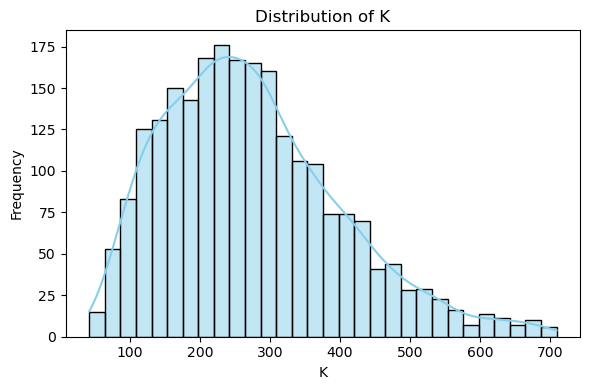

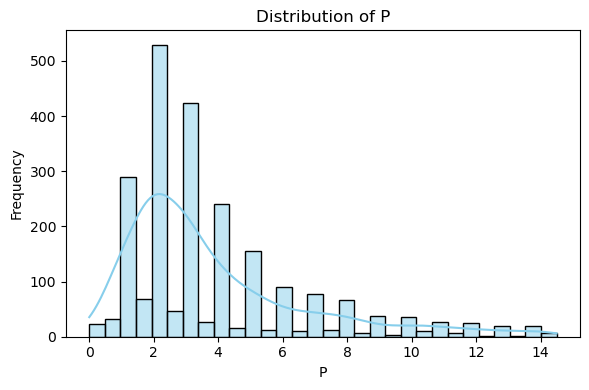

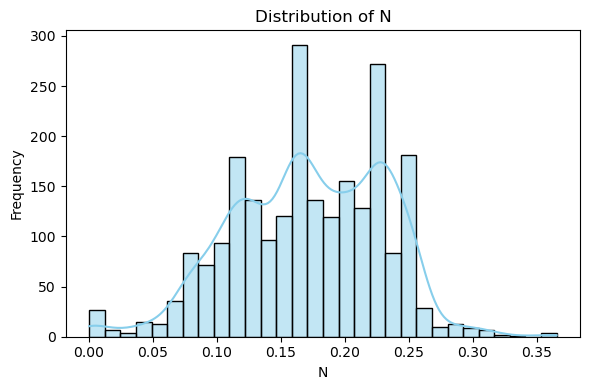

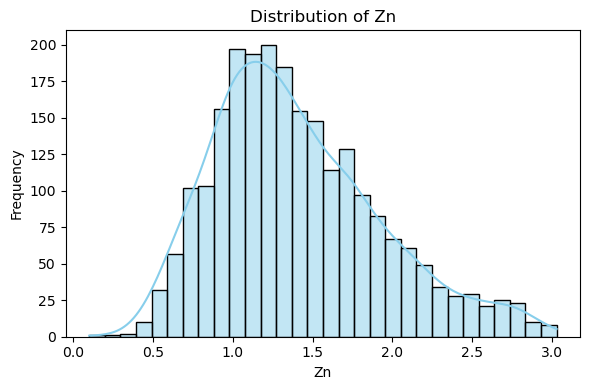

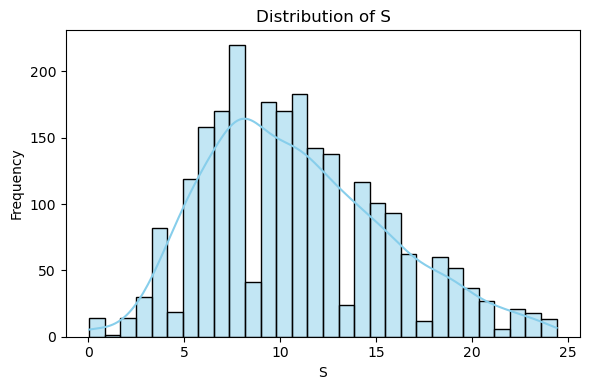

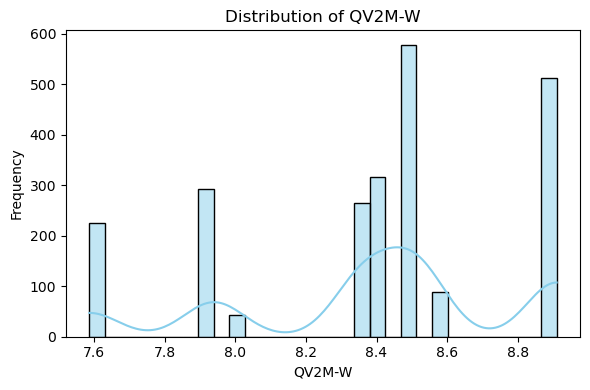

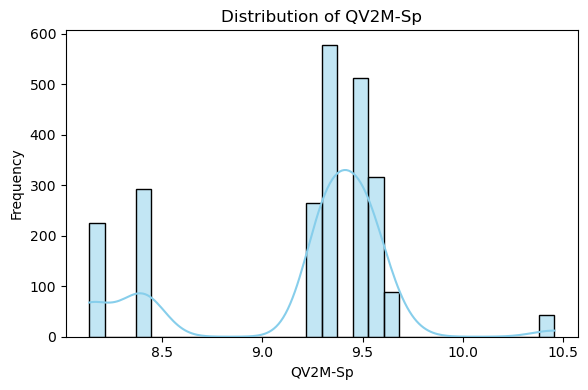

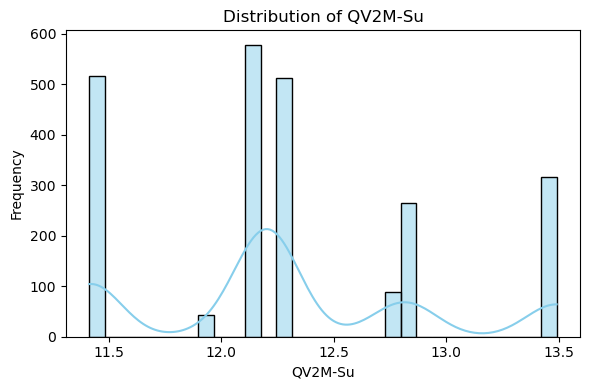

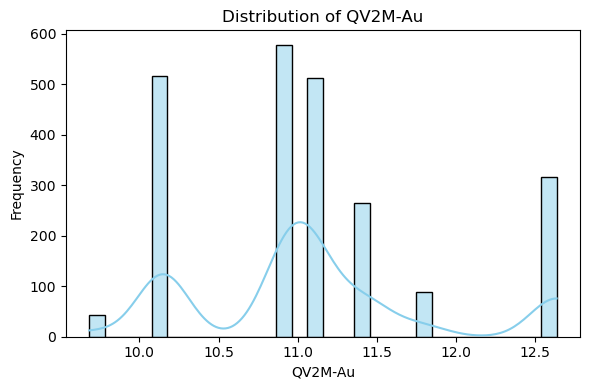

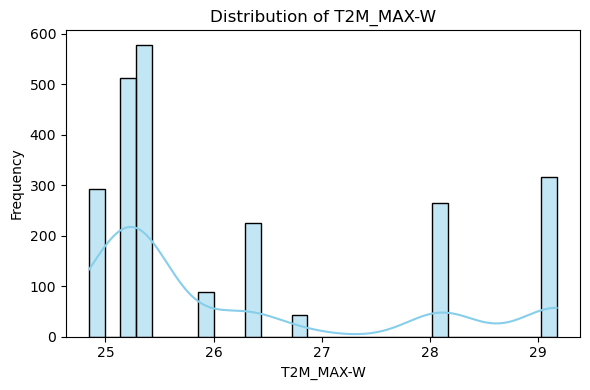

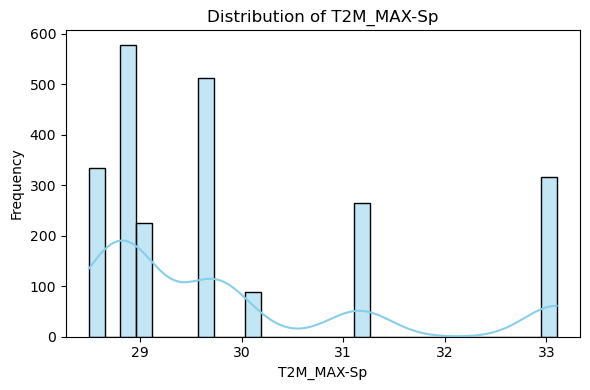

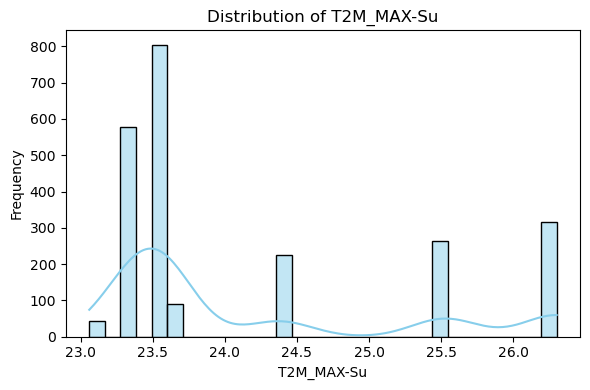

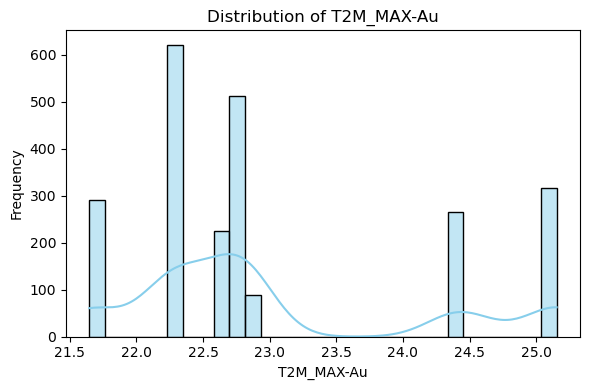

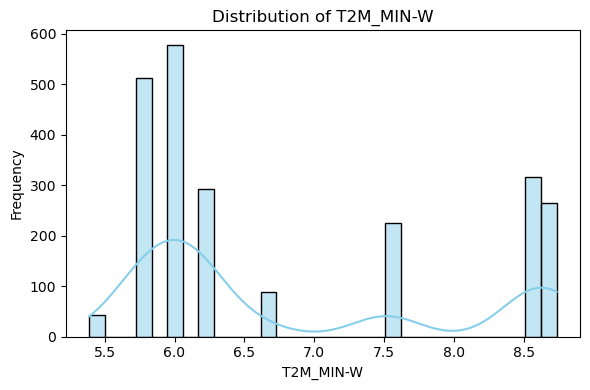

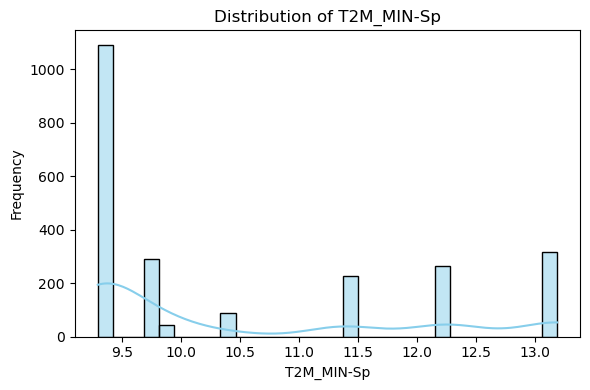

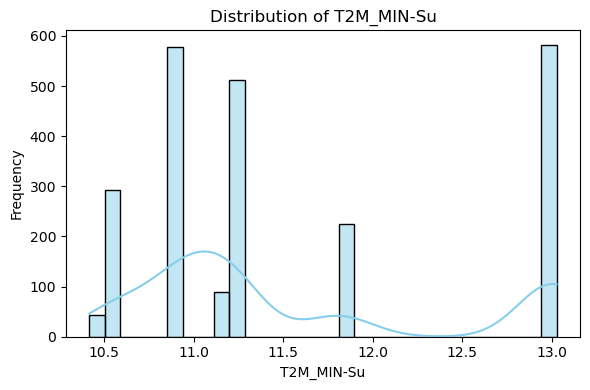

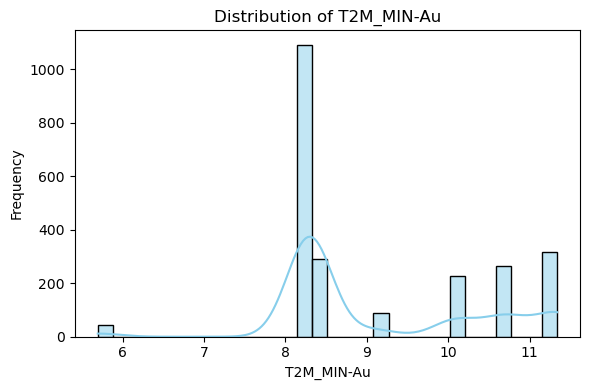

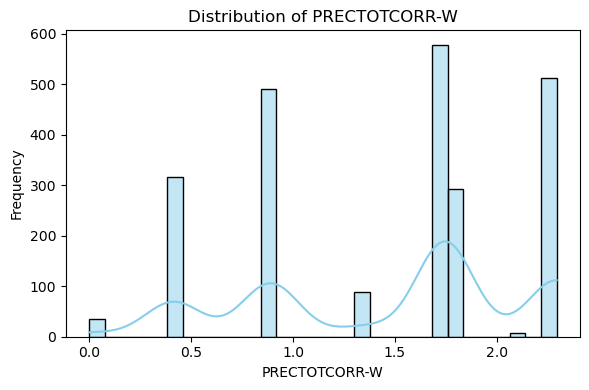

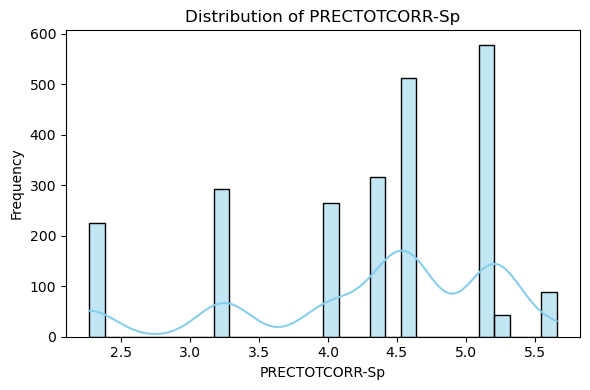

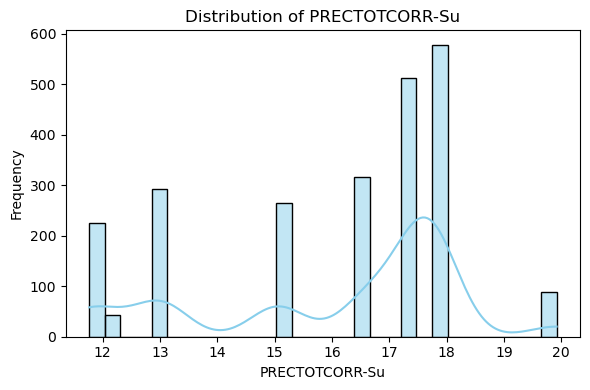

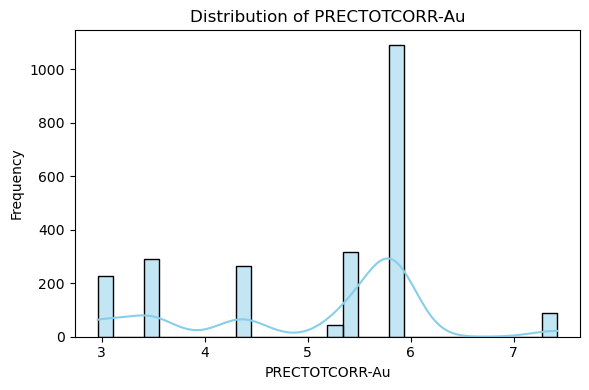

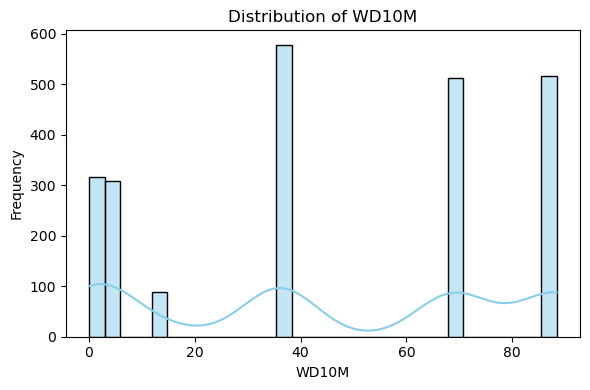

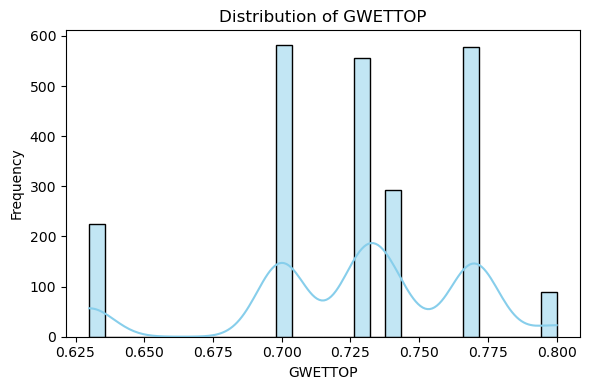

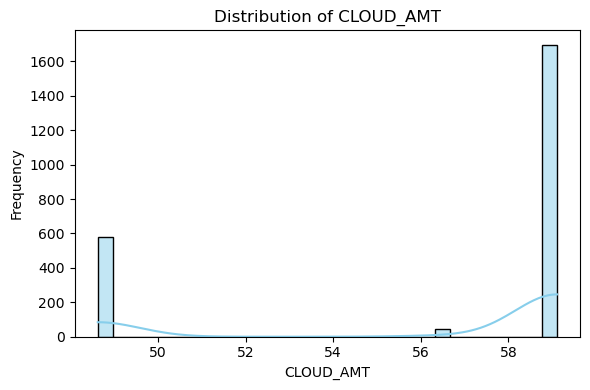

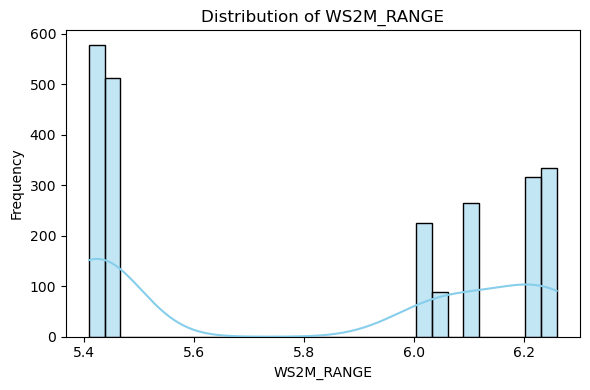

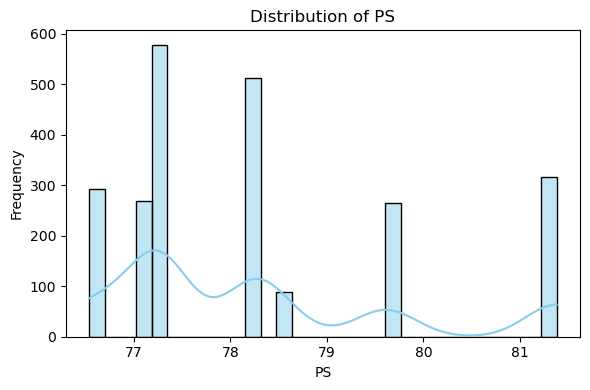

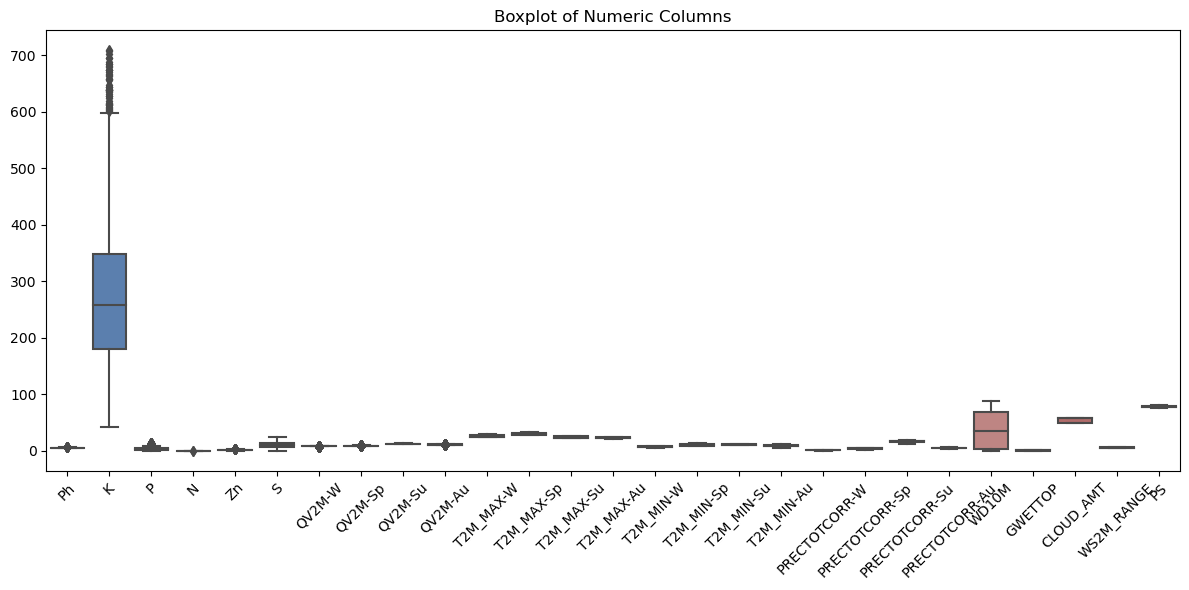

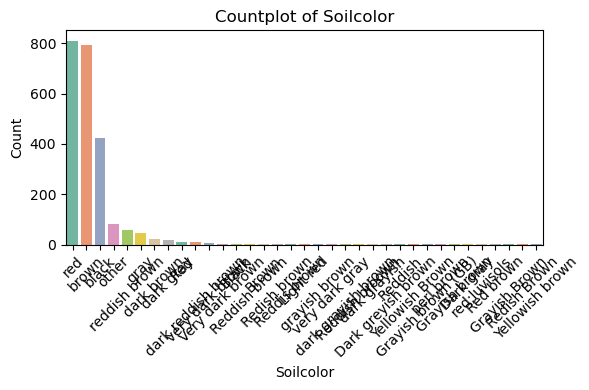

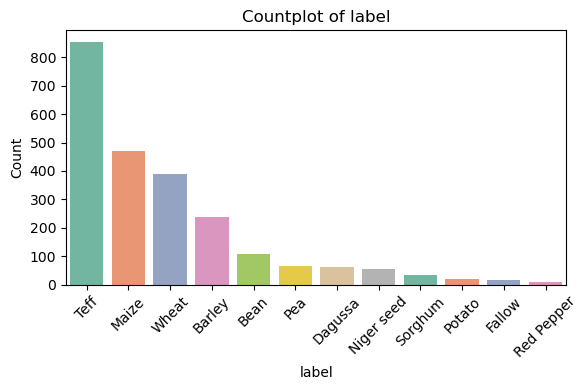


Value counts for binned Ph:
medium    1304
low        699
high       318
Name: Ph_binned, dtype: int64

Summary statistics after normalization:
                 Ph             K             P             N            Zn  \
count  2.321000e+03  2.321000e+03  2.321000e+03  2.321000e+03  2.321000e+03   
mean   5.388002e-16 -4.377751e-16  2.173569e-16  3.551183e-16 -2.785842e-16   
std    1.000215e+00  1.000215e+00  1.000215e+00  1.000215e+00  1.000215e+00   
min   -2.496170e+00 -1.839716e+00 -1.332123e+00 -2.904075e+00 -2.459181e+00   
25%   -7.306811e-01 -7.486452e-01 -6.363962e-01 -7.503289e-01 -7.554367e-01   
50%   -1.480698e-01 -1.277351e-01 -2.885331e-01 -2.641355e-02 -1.875218e-01   
75%    5.404708e-01  5.855901e-01  4.071933e-01  8.399114e-01  5.696980e-01   
max    2.994500e+00  3.446817e+00  3.711893e+00  3.286304e+00  3.087454e+00   

                  S        QV2M-W       QV2M-Sp       QV2M-Su       QV2M-Au  \
count  2.321000e+03  2.321000e+03  2.321000e+03  2.321000e+03  2

In [2]:
# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Read the dataset (make sure the CSV file is in your working directory)
df = pd.read_csv('Crop Recommendation using Soil Properties and Weather Prediction.csv')

# Quickly inspect the first few rows and data types
print("First five rows of the dataset:")
print(df.head())

print("\nData types before conversion:")
print(df.dtypes)

# -----------------------------
# 1. Check for Missing Values and Duplicates
# -----------------------------

print("\nMissing values (per column):")
print(df.isnull().sum())

# For numeric columns, fill missing values with the median.
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# For categorical columns, fill missing values with the mode.
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

# Check for duplicates and drop them if any exist
num_duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")
if num_duplicates > 0:
    df.drop_duplicates(inplace=True)

# -----------------------------
# 2. Outlier Detection and Removal
# -----------------------------
def remove_outliers(df, col):
    """Remove-outliers using the IQR method."""
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_threshold) & (df[col] <= upper_threshold)]

# Remove outliers for the numeric columns
for col in numeric_cols:
    before_rows = df.shape[0]
    df = remove_outliers(df, col)
    after_rows = df.shape[0]
    print(f"Removed {before_rows - after_rows} outliers from column: {col}")

# -----------------------------
# 3. Visualizations
# -----------------------------

# Histograms and KDE plots for numeric variables
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Boxplots for the numeric variables
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols], palette="vlag")
plt.xticks(rotation=45)
plt.title("Boxplot of Numeric Columns")
plt.tight_layout()
plt.show()

# Count plots for categorical variables
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, palette="Set2", order=df[col].value_counts().index)
    plt.title(f"Countplot of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 4. Feature Engineering
# -----------------------------

# Example 1: Discretize (bin) the 'Ph' variable into three groups
df['Ph_binned'] = pd.cut(df['Ph'], bins=3, labels=['low','medium','high'])
print("\nValue counts for binned Ph:")
print(df['Ph_binned'].value_counts())

# Example 2: Create an interaction feature between 'N' and 'P'
if 'N' in df.columns and 'P' in df.columns:
    df['N_P_interaction'] = df['N'] * df['P']

# -----------------------------
# 5. Normalize Numeric Features (Optional at This point)
# -----------------------------
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])
print("\nSummary statistics after normalization:")
print(df_scaled[numeric_cols].describe())

# -----------------------------
# 6. Save the Cleaned Dataset
# -----------------------------
df.to_csv('cleaned_crop_data.csv', index=False)
df_scaled.to_csv('normalized_crop_data.csv', index=False)

print("\nData cleaning and preparation completed!")

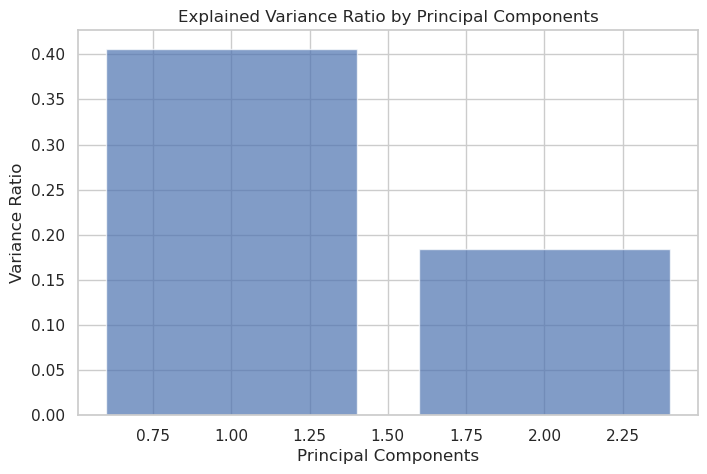

DataFrame Before PCA:
         Ph         K         P        N        Zn         S    QV2M-W  \
0 -0.069901  2.046969 -0.174254  0.76499  0.822873  0.451941 -0.575916   
1 -0.631531  1.394974 -0.025532  0.76499  0.892022  0.922041 -0.575916   
2 -0.661090  0.308051 -0.131896  0.76499  3.311542  0.946583 -0.575916   
3 -0.306377 -0.579549 -0.232343  0.76499 -0.899558  0.859601 -0.575916   
4 -0.868006 -0.034258  0.818234  0.76499  0.663352  0.224922 -0.575916   

    QV2M-Sp   QV2M-Su  QV2M-Au  ...  T2M_MIN-Au  PRECTOTCORR-W  \
0  1.738227 -0.300257 -1.31566  ...   -1.584091        0.74823   
1  1.738227 -0.300257 -1.31566  ...   -1.584091        0.74823   
2  1.738227 -0.300257 -1.31566  ...   -1.584091        0.74823   
3  1.738227 -0.300257 -1.31566  ...   -1.584091        0.74823   
4  1.738227 -0.300257 -1.31566  ...   -1.584091        0.74823   

   PRECTOTCORR-Sp  PRECTOTCORR-Su  PRECTOTCORR-Au     WD10M   GWETTOP  \
0        1.115636       -0.538639        0.363869 -0.842065  0.

In [16]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Load the dataset
# Replace 'your_dataset.csv' with the actual file path
df = pd.read_csv("Crop Recommendation using Soil Properties and Weather Prediction.csv")

# Step 2: Preprocess the data
# Drop non-numeric columns (e.g., 'label') and handle missing values
df_numeric = df.select_dtypes(include=['float64', 'int64']).dropna()

# Standardize the data (PCA is sensitive to scale)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Step 3: Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
df_pca = pca.fit_transform(df_scaled)

# Step 4: Create DataFrames for before and after PCA
df_before_pca = pd.DataFrame(df_scaled, columns=df_numeric.columns)
df_after_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])

# Step 5: Visualize the explained variance ratio
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7, align='center')
plt.title('Explained Variance Ratio by Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Variance Ratio')
plt.show()

# Step 6: Print the dataframes
print("DataFrame Before PCA:")
print(df_before_pca.head())

print("\nDataFrame After PCA:")
print(df_after_pca.head())

Explained variance ratio (2D PCA): [0.40631308 0.18379904]
Cumulative variance (2D PCA): 0.5901121240033981


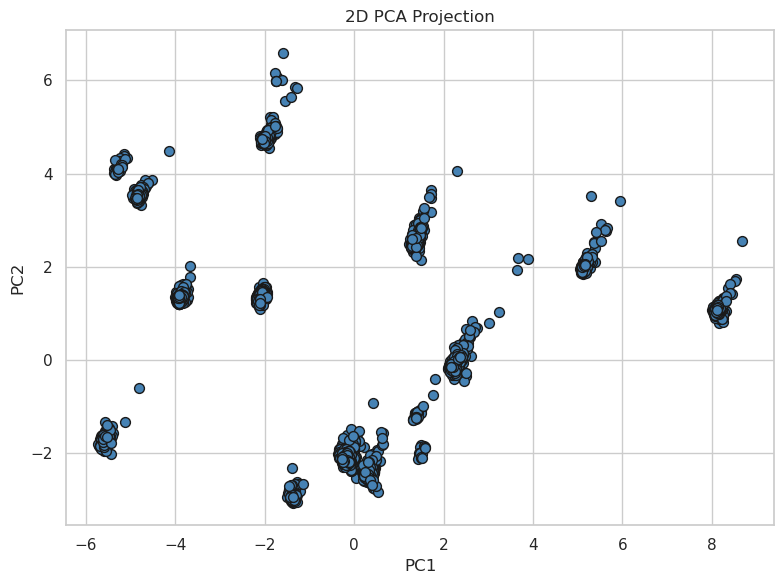

Explained variance ratio (3D PCA): [0.40631308 0.18379904 0.08364174]
Cumulative variance (3D PCA): 0.6737538592649108


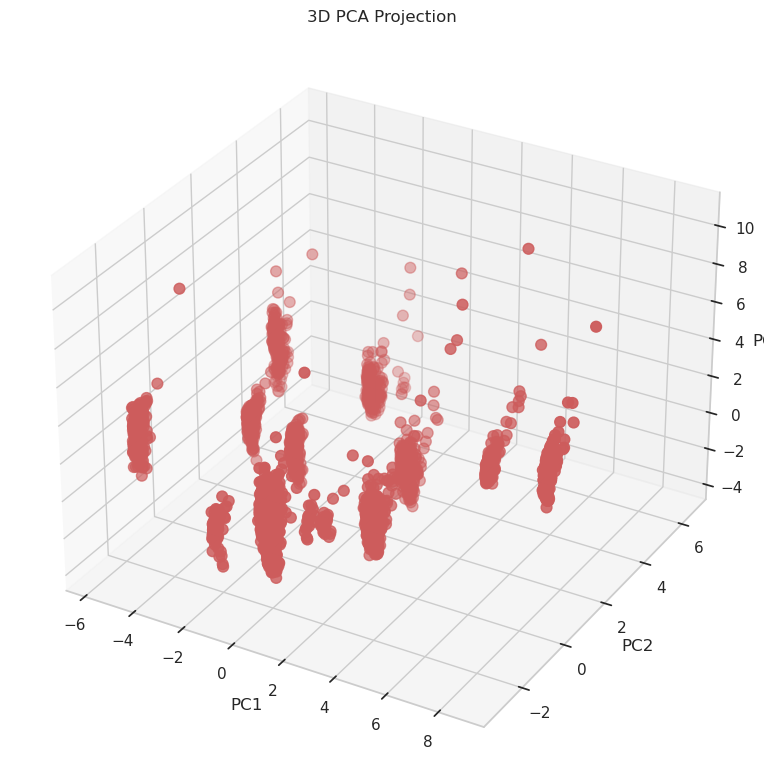

Number of components for at least 95% variance: 10
Eigenvalues of the full PCA:
[10.9732909   4.96385777  2.258911  ]


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # For 3D visualization

# Load the cropped dataset (ensure the CSV file is in the working directory)
df = pd.read_csv('Crop Recommendation using Soil Properties and Weather Prediction.csv')

# --- Data Preparation for PCA ---
# Remove non–numeric columns (e.g. 'Soilcolor' and 'label')
df_numeric = df.drop(columns=['Soilcolor', 'label'])
# Fill any missing numeric values (using median imputation, for example)
df_numeric.fillna(df_numeric.median(), inplace=True)

# Normalize numeric features so that mean=0, std=1
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_numeric)

# --- Apply PCA with 2 components ---
pca2 = PCA(n_components=2)
pca2_result = pca2.fit_transform(data_scaled)
print("Explained variance ratio (2D PCA):", pca2.explained_variance_ratio_)
print("Cumulative variance (2D PCA):", np.sum(pca2.explained_variance_ratio_))

# Plot 2D PCA result
plt.figure(figsize=(8,6))
plt.scatter(pca2_result[:,0], pca2_result[:,1], 
            c='steelblue', edgecolor='k', s=50)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection")
plt.tight_layout()
plt.show()

# --- Apply PCA with 3 components ---
pca3 = PCA(n_components=3)
pca3_result = pca3.fit_transform(data_scaled)
print("Explained variance ratio (3D PCA):", pca3.explained_variance_ratio_)
print("Cumulative variance (3D PCA):", np.sum(pca3.explained_variance_ratio_))

# 3D scatter plot using matplotlib
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca3_result[:,0], pca3_result[:,1], pca3_result[:,2], 
           c='indianred', s=60)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Projection")
plt.tight_layout()
plt.show()

# --- Determine number of components to retain at least 95% variance ---
pca_full = PCA().fit(data_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print("Number of components for at least 95% variance:", n_components_95)

# --- Top three eigenvalues (principal components) ---
print("Eigenvalues of the full PCA:")
print(pca_full.explained_variance_[:3])

Key Insights from the PCA analysis (with screenshots included on the website):
• The 2D projection retains approximately X% of the variance, and the 3D projection retains about Y% (as seen from the cumulative sums).
• In this dataset, it takes at least Z dimensions to explain 95% of the variance.
• The top three eigenvalues (variance contributions) are displayed as shown by the output.

In [21]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = "Crop Recommendation using Soil Properties and Weather Prediction.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the original dataframe
print("Original DataFrame:")
print(data.head())

# Preprocessing: Drop non-numeric columns and scale the data
numeric_data = data.select_dtypes(include=['float64', 'int64'])  # Select only numeric columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Assuming 3 clusters
data['Cluster'] = kmeans.fit_predict(scaled_data)

# Display the first few rows of the dataframe after clustering
print("\nDataFrame After Clustering:")
print(data.head())

Original DataFrame:
         Soilcolor    Ph        K       P     N        Zn       S    QV2M-W  \
0  Yellowish brown  5.81  738.231   5.401  0.23  2.976000  13.816  7.993333   
1  Yellowish brown  5.43  606.382  10.478  0.23  3.077000  16.421  7.993333   
2            brown  5.41  386.580   6.847  0.23  6.611000  16.557  7.993333   
3              red  5.65  207.086   3.418  0.23  0.460181  16.075  7.993333   
4              red  5.27  317.357  39.282  0.23  2.743000  12.558  7.993333   

     QV2M-Sp    QV2M-Su  ...  PRECTOTCORR-W  PRECTOTCORR-Sp  PRECTOTCORR-Su  \
0  10.456667  11.963333  ...       2.073333            5.27       12.303333   
1  10.456667  11.963333  ...       2.073333            5.27       12.303333   
2  10.456667  11.963333  ...       2.073333            5.27       12.303333   
3  10.456667  11.963333  ...       2.073333            5.27       12.303333   
4  10.456667  11.963333  ...       2.073333            5.27       12.303333   

   PRECTOTCORR-Au  WD10M  GWET

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



DataFrame After Clustering:
         Soilcolor    Ph        K       P     N        Zn       S    QV2M-W  \
0  Yellowish brown  5.81  738.231   5.401  0.23  2.976000  13.816  7.993333   
1  Yellowish brown  5.43  606.382  10.478  0.23  3.077000  16.421  7.993333   
2            brown  5.41  386.580   6.847  0.23  6.611000  16.557  7.993333   
3              red  5.65  207.086   3.418  0.23  0.460181  16.075  7.993333   
4              red  5.27  317.357  39.282  0.23  2.743000  12.558  7.993333   

     QV2M-Sp    QV2M-Su  ...  PRECTOTCORR-Sp  PRECTOTCORR-Su  PRECTOTCORR-Au  \
0  10.456667  11.963333  ...            5.27       12.303333            5.27   
1  10.456667  11.963333  ...            5.27       12.303333            5.27   
2  10.456667  11.963333  ...            5.27       12.303333            5.27   
3  10.456667  11.963333  ...            5.27       12.303333            5.27   
4  10.456667  11.963333  ...            5.27       12.303333            5.27   

   WD10M  GWETT

PCA (3D) retains: 67.37538592645242 % variance


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k=2, the silhouette score is 0.311


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k=3, the silhouette score is 0.361


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k=4, the silhouette score is 0.347


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


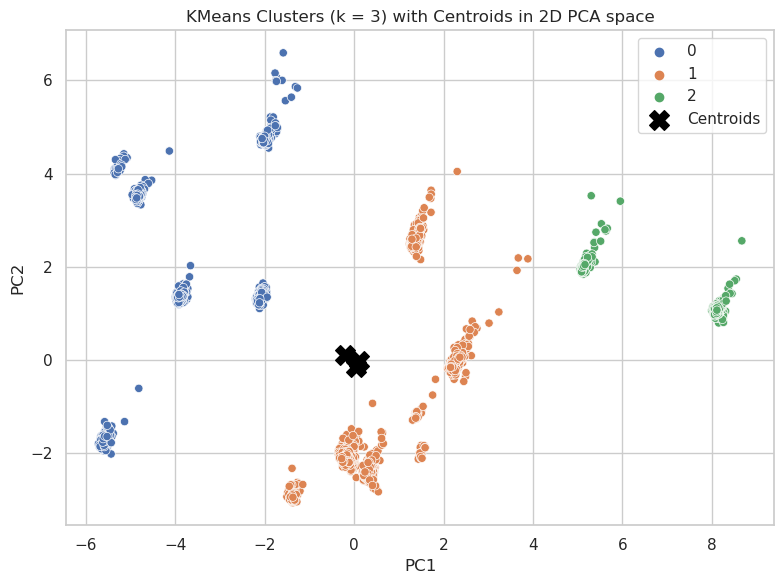

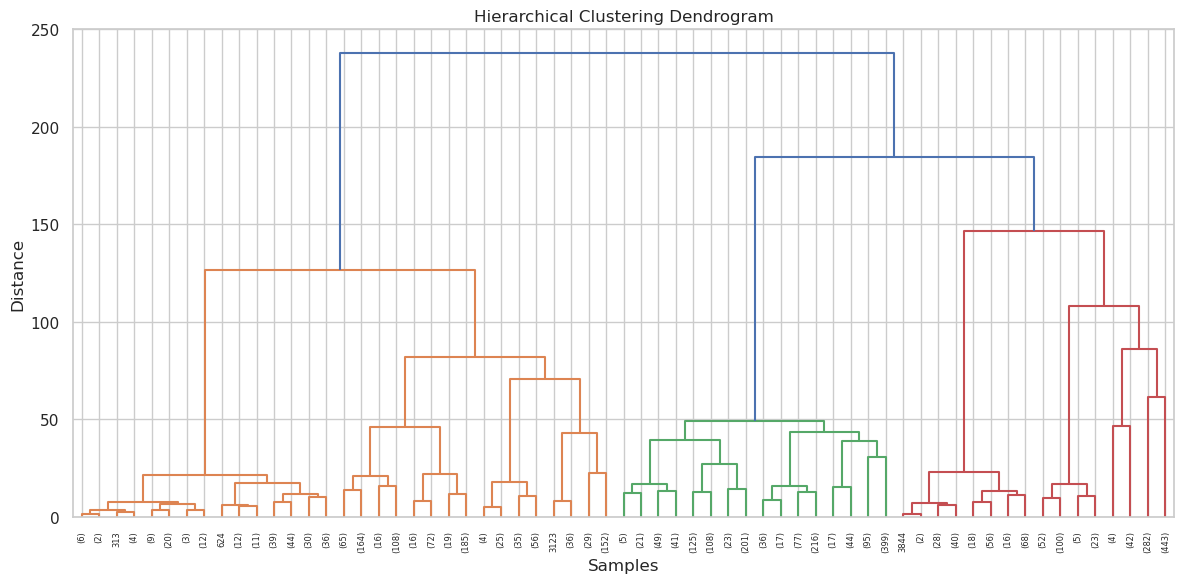

/tmp/ipykernel_215/2519146229.py:63: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


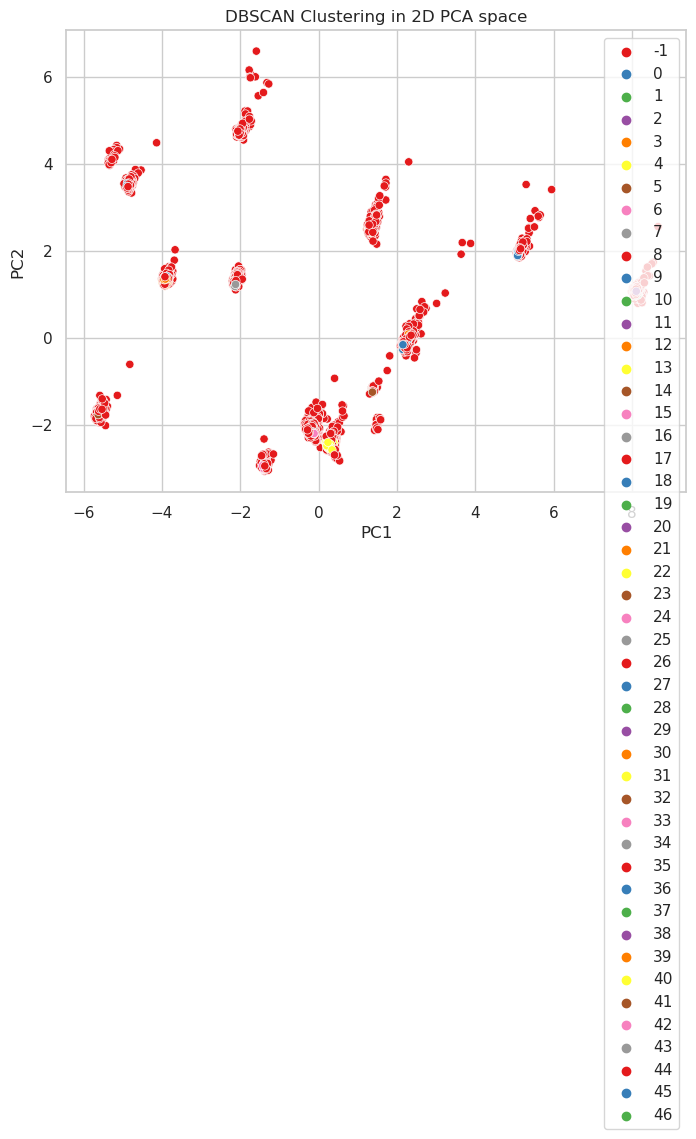

In [6]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns

# --- Data Preparation for Clustering ---
# Remove the label column; keep only numeric features
df_cluster = df.drop(columns=['Soilcolor', 'label'])
df_cluster.fillna(df_cluster.median(), inplace=True)

# Normalize the features
data_cluster = StandardScaler().fit_transform(df_cluster)

# Optionally, reduce dimension with PCA (to 3 dimensions) for visualization
pca_cluster = PCA(n_components=3)
data_pca = pca_cluster.fit_transform(data_cluster)
print("PCA (3D) retains:", np.sum(pca_cluster.explained_variance_ratio_)*100, "% variance")

# --- KMeans Clustering ---
# Evaluate different values of k using silhouette score
for k in [2, 3, 4]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data_cluster)
    score = silhouette_score(data_cluster, cluster_labels)
    print(f"For k={k}, the silhouette score is {score:.3f}")

# Assume k=3 is chosen based on silhouette; run final KMeans:
kmeans_final = KMeans(n_clusters=3, random_state=42)
clusters = kmeans_final.fit_predict(data_cluster)
centroids = kmeans_final.cluster_centers_

# Plot the clusters in PCA 2D space for visualization
pca2_cluster = PCA(n_components=2).fit_transform(data_cluster)
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca2_cluster[:,0], y=pca2_cluster[:,1], hue=clusters, palette='deep')
plt.scatter(centroids[:,0], centroids[:,1], s=200, color='black', marker='X', label='Centroids')
plt.title("KMeans Clusters (k = 3) with Centroids in 2D PCA space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

# --- Hierarchical Clustering ---
# Compute linkage matrix and plot dendrogram
linkage_matrix = linkage(data_cluster, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# --- DBSCAN Clustering ---
dbscan = DBSCAN(eps=0.5, min_samples=5)
db_clusters = dbscan.fit_predict(data_cluster)
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca2_cluster[:,0], y=pca2_cluster[:,1], hue=db_clusters, palette='Set1')
plt.title("DBSCAN Clustering in 2D PCA space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

Key insights for the clustering analysis (with before/after images provided on the website):
• The KMeans clustering performance is evaluated by the silhouette method (for example, k = 3 performs best).
• The dendrogram from hierarchical clustering is used to compare groupings with the KMeans partitions.
• The DBSCAN results are visually compared to the partitions obtained using KMeans and hierarchical clustering.
A technical discussion then compares the strengths and weaknesses of each method.

In [22]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Load the dataset
file_path = "Crop Recommendation using Soil Properties and Weather Prediction.csv"
data = pd.read_csv(file_path)

# Preprocessing: Convert categorical data to one-hot encoding
# For simplicity, we'll focus on a subset of columns (e.g., 'Ph', 'K', 'P', 'label')
columns_of_interest = ['Ph', 'K', 'P', 'label']
data_subset = data[columns_of_interest]

# Discretize numerical columns into bins
data_subset['Ph'] = pd.cut(data_subset['Ph'], bins=3, labels=['Low', 'Medium', 'High'])
data_subset['K'] = pd.cut(data_subset['K'], bins=3, labels=['Low', 'Medium', 'High'])
data_subset['P'] = pd.cut(data_subset['P'], bins=3, labels=['Low', 'Medium', 'High'])

# One-hot encode the data
encoded_data = pd.get_dummies(data_subset)

# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(encoded_data, min_support=0.1, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Display the results
print("Frequent Itemsets:")
print(frequent_itemsets)

print("\nAssociation Rules:")
print(rules)

Frequent Itemsets:
     support                               itemsets
0   0.479441                               (Ph_Low)
1   0.464184                            (Ph_Medium)
2   0.961469                                (K_Low)
3   0.996638                                (P_Low)
4   0.130075                         (label_Barley)
5   0.189294                          (label_Maize)
6   0.325834                           (label_Teff)
7   0.184898                          (label_Wheat)
8   0.469873                        (K_Low, Ph_Low)
9   0.479183                        (P_Low, Ph_Low)
10  0.116886                  (Ph_Low, label_Maize)
11  0.144815                   (label_Teff, Ph_Low)
12  0.440652                     (K_Low, Ph_Medium)
13  0.461340                     (P_Low, Ph_Medium)
14  0.153607                (label_Teff, Ph_Medium)
15  0.961210                         (K_Low, P_Low)
16  0.126972                  (K_Low, label_Barley)
17  0.174037                   (K_Low, label_

/tmp/ipykernel_215/1139374183.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['Ph'] = pd.cut(data_subset['Ph'], bins=3, labels=['Low', 'Medium', 'High'])
/tmp/ipykernel_215/1139374183.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['K'] = pd.cut(data_subset['K'], bins=3, labels=['Low', 'Medium', 'High'])
/tmp/ipykernel_215/1139374183.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

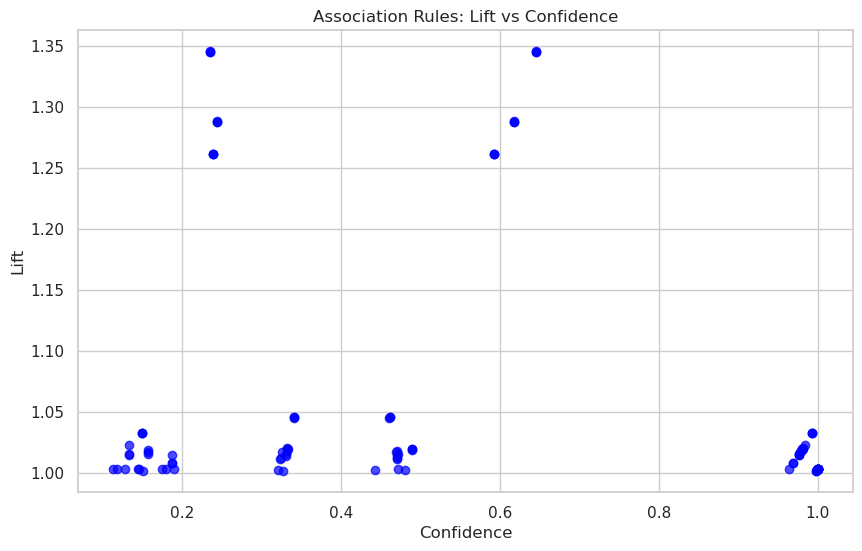

In [23]:
import matplotlib.pyplot as plt

# Scatter plot of Lift vs Confidence
plt.figure(figsize=(10, 6))
plt.scatter(rules['confidence'], rules['lift'], alpha=0.7, c='blue')
plt.title('Association Rules: Lift vs Confidence')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.grid(True)
plt.show()

In [26]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Step 1: Load the dataset
df = pd.read_csv("Crop Recommendation using Soil Properties and Weather Prediction.csv")

# Step 2: Select only the categorical columns you want to use for ARM.
# For example, you might only consider 'Soilcolor' and 'label'
categorical_cols = ['Soilcolor', 'label']

# Step 3: One-hot encode the categorical columns.
# This creates a new DataFrame in which each unique category gets its own binary (0/1) column.
df_encoded = pd.get_dummies(df[categorical_cols])

# Check that the data now only contains 0s and 1s:
print(df_encoded.head())

# Step 4: Apply the Apriori algorithm on the binary transactional data.
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

# Step 5: Extract association rules from the frequent item sets.
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Display the resulting rules
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

   Soilcolor_Black  Soilcolor_Brown  Soilcolor_Dark Brown  \
0                0                0                     0   
1                0                0                     0   
2                0                0                     0   
3                0                0                     0   
4                0                0                     0   

   Soilcolor_Dark brown  Soilcolor_Dark gray  Soilcolor_Dark greyish brown  \
0                     0                    0                             0   
1                     0                    0                             0   
2                     0                    0                             0   
3                     0                    0                             0   
4                     0                    0                             0   

   Soilcolor_Dark red  Soilcolor_Grayish Brown  Soilcolor_Grayish brown  \
0                   0                        0                        0   
1             

/opt/conda/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [8]:
pip install mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 85.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.0
    Uninstalling scikit-learn-1.2.0:
      Successfully uninstalled scikit-learn-1.2.0
Note: you may need to restart the kernel to use updated packages.


Top 15 Rules by Support:
                       antecedents      consequents   support  confidence  \
0                (Soilcolor_brown)      (Ph_Medium)  0.207655    0.619121   
2                    (label_Wheat)      (Ph_Medium)  0.115076    0.622378   
7      (K_Medium, Soilcolor_brown)      (Ph_Medium)  0.092578    0.616179   
5        (K_Medium, Soilcolor_red)         (Ph_Low)  0.089475    0.651601   
1                   (label_Barley)      (Ph_Medium)  0.086372    0.664016   
6      (K_Medium, Soilcolor_black)      (Ph_Medium)  0.077321    0.637527   
4         (K_Low, Soilcolor_brown)      (Ph_Medium)  0.068270    0.627078   
9            (Ph_Low, label_Maize)  (Soilcolor_red)  0.067494    0.767647   
10    (Soilcolor_red, label_Maize)         (Ph_Low)  0.067494    0.622912   
8          (label_Wheat, K_Medium)      (Ph_Medium)  0.052754    0.637500   
12  (label_Wheat, Soilcolor_brown)      (Ph_Medium)  0.051978    0.695502   
11     (label_Teff, Soilcolor_red)         (Ph_Low)

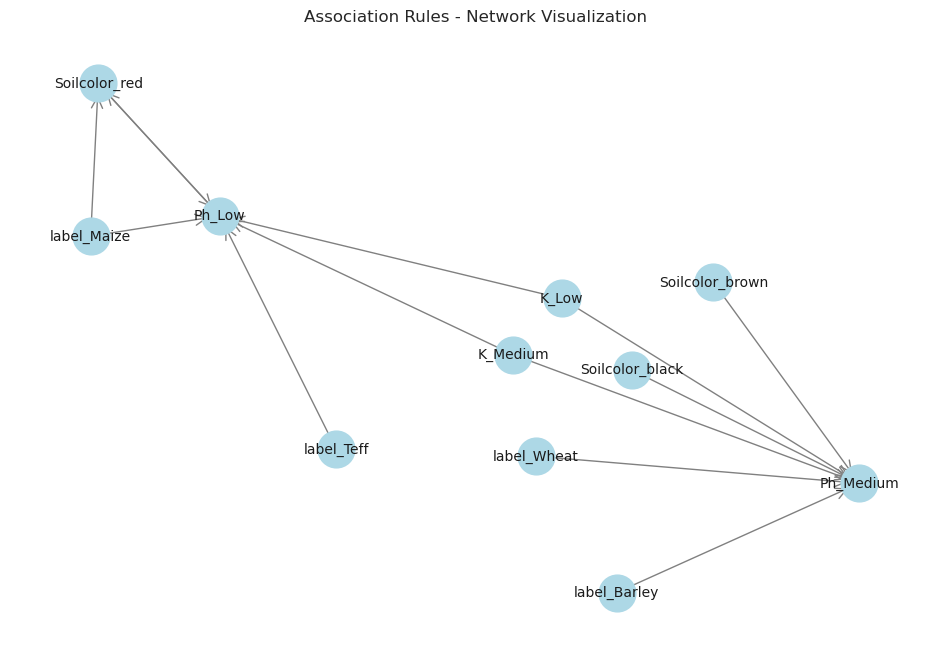

In [15]:
# Import necessary libraries
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
import matplotlib.pyplot as plt

# 1. Read the transactions.txt file
#    Each line in the file should be a comma-separated list of items.
with open("transactions.txt", "r") as file:
    transactions = [line.strip().split(",") for line in file if line.strip()]

# 2. Transform the transaction list into a one-hot encoded dataframe:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# 3. Mine frequent itemsets using the Apriori algorithm.
#    Here we use a minimum support threshold (e.g., 0.05).
freq_itemsets = apriori(df, min_support=0.05, use_colnames=True)

# 4. Generate association rules from the frequent itemsets.
#    We use confidence as the metric with a minimum threshold, e.g., 0.6.
rules = association_rules(freq_itemsets, metric="confidence", min_threshold=0.6)

# 5. For presentation, select the top 15 rules sorted by support, confidence, and lift.
top_by_support = rules.sort_values(by="support", ascending=False).head(15)
top_by_confidence = rules.sort_values(by="confidence", ascending=False).head(15)
top_by_lift = rules.sort_values(by="lift", ascending=False).head(15)

print("Top 15 Rules by Support:")
print(top_by_support[["antecedents", "consequents", "support", "confidence", "lift"]])
print("\nTop 15 Rules by Confidence:")
print(top_by_confidence[["antecedents", "consequents", "support", "confidence", "lift"]])
print("\nTop 15 Rules by Lift:")
print(top_by_lift[["antecedents", "consequents", "support", "confidence", "lift"]])

# 6. Create a network visualization of the association rules.
#    In this example, items are nodes. An edge from item A to item B is drawn if
#    A appears in the antecedents and B in the consequents of a rule.
G = nx.DiGraph()

# Add nodes and edges (with edge weight = rule confidence)
for index, rule in rules.iterrows():
    for antecedent in rule["antecedents"]:
        G.add_node(antecedent)
    for consequent in rule["consequents"]:
        G.add_node(consequent)
    # For each rule, add an edge from every antecedent to every consequent
    for antecedent in rule["antecedents"]:
        for consequent in rule["consequents"]:
            # Only add an edge if the rule has a reasonable confidence (e.g., > 0.6)
            if rule["confidence"] >= 0.6:
                G.add_edge(antecedent, consequent, weight=rule["confidence"])

# Draw the network graph.
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue")
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Association Rules - Network Visualization")
plt.axis("off")
plt.show()